In [1]:
import pandas as pd
import numpy as np

In [2]:
fotocasa = pd.read_csv("fotocasa_eda.csv")

In [3]:
fotocasa.columns

Index(['Air_Conditioner', 'Antiquity', 'Bathrooms', 'Borough',
       'Community_Zone', 'Concierge', 'District', 'Elevator',
       'Energy_Consumption', 'Ensuite', 'Equipped_Kitchen', 'Floor',
       'Furnished', 'Garden', 'Price', 'Rooms', 'Size', 'Swimming_Pool',
       'Terrace', 'Type'],
      dtype='object')

In [4]:
X = fotocasa.drop("Price", axis=1)
y = fotocasa["Price"]

In [5]:
import statsmodels.api as sm

In [6]:
reg_mod = sm.OLS(y,pd.get_dummies(X)).fit()
mea = reg_mod.resid.abs().mean()
r2 = reg_mod.rsquared
print("MEA: ", mea, " R2: ", r2)

MEA:  216.93151104385353  R2:  0.7249062615670048


In [7]:
reg_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     111.6
Date:                Sun, 14 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:01:36   Log-Likelihood:                -63564.
No. Observations:                8805   AIC:                         1.275e+05
Df Residuals:                    8601   BIC:                         1.290e+05
Df Model:                         203                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Air_Conditioner                        133.2258      8.281     16.087      0.000     116.992     149.459
Bathrooms                              257.7070      8.211     31.385      0.000     241.611     273.803
Community_Zone                         -55.9598     15.488     -3.613      0.000     -86.319     -25.600
Concierge                               -3.9868      9.131     -0.437      0.662     -21.886      13.913
Elevator                               -34.2014     10.053     -3.402      0.001     -53.907     -14.496
Ensuite                                125.3403     11.420     10.975      0.000     102.954     147.726
Equipped_Kitchen                       -19.2236     11.187     -1.718      0.086     -41.154       2.707
Furnished                              -27.0442      7.813     -3.461      0.001     -42.359     -11.729
Garden                                   0.0046     18.452      0.000      1.000     -36.166      36.175
Rooms                                   88.0215      5.475     16.076      0.000      77.289      98.754
Size                                     4.0839      0.109     37.618      0.000       3.871       4.297
Swimming_Pool                           80.5210     17.149      4.695      0.000      46.905     114.137
Terrace                                 33.9758      9.635      3.526      0.000      15.088      52.864
Antiquity_+100                         -22.1031     17.509     -1.262      0.207     -56.425      12.219
Antiquity_1-5                          261.2267     30.949      8.441      0.000     200.560     321.894
Antiquity_10-20                         10.7547     16.266      0.661      0.509     -21.131      42.641
Antiquity_20-30                        -26.7673     19.810     -1.351      0.177     -65.600      12.065
Antiquity_30-50                        -30.1752     14.181     -2.128      0.033     -57.974      -2.377
Antiquity_5-10                          56.9006     36.310      1.567      0.117     -14.276     128.077
Antiquity_50-70                         15.0070     14.501      1.035      0.301     -13.418      43.432
Antiquity_70-100                        -5.9243     15.986     -0.371      0.711     -37.261      25.413
Antiquity_<1                           142.7793     30.506      4.680      0.000      82.981     202.578
Borough_Abrantes                        11.7196    141.977      0.083      0.934    -266.589     290.028
Borough_Acacias                        -63.1710    100.307     -0.630      0.529    -259.797     133.455
Borough_Adelfas                       -112.7226    161.644     -0.697      0.486    -429.584     204.139
Borough_Aeropuerto                     183.6059    363.493      0.505      0.613    -528.927     896.139
Borough_Alameda de Osuna              

# Training

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import sklearn_dummies as skdm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [9]:
# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1492)

### Linear regression

In [10]:
# Linear regression pipeline
pipeline_lr = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore')), 
                        ('lr', LinearRegression())])
cv_score_lr = cross_val_score(pipeline_lr, X_train, y_train, scoring = "neg_mean_absolute_error", cv=5)
print("MAE: ", np.quantile(-cv_score_lr,[0.025,0.975]),"\n",np.mean(-cv_score_lr))

MAE:  [213.97880521 229.21031801] 
 221.48431854321225


In [11]:
# Predicting
pipeline_lr.fit(X_train, y_train)
(y_test-pipeline_lr.predict(X_test)).abs().mean()

211.27410240774032

### Ridge regression

In [12]:
# Ridge regression pipeline
pipeline_r = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore')), 
                        ('r', Ridge(random_state = 1492))])
cv_score_r = cross_val_score(pipeline_r, X_train, y_train, scoring = "neg_mean_absolute_error", cv=5)
print("MAE: ", np.quantile(-cv_score_r,[0.025,0.975]),"\n")

MAE:  [210.84821003 224.67704906] 



In [13]:
alpha = []
err = []
err_min = []
err_max = []
err_std = []
for i in range(1,200,2):
    pipeline_r = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore')), 
                        ('r', Ridge(random_state = 1492, alpha = i/100))])
    cv_score_r = cross_val_score(pipeline_r, X_train, y_train, 
                                  scoring = "neg_mean_absolute_error", cv=5)
    alpha.append(i/100)
    err.append(np.mean(cv_score_r))
    err_min.append(np.min(cv_score_r))
    err_max.append(np.max(cv_score_r))
    err_std.append(np.std(cv_score_r))
print(np.mean(err))

-219.7414154336303


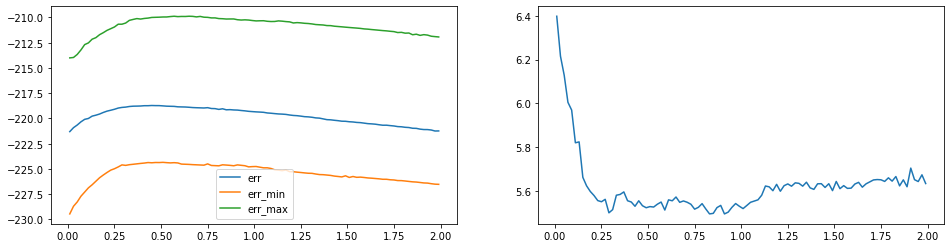

In [14]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(ncols = 2, figsize = (16, 4))
ax[0].plot(alpha, err, label = "err")
ax[0].plot(alpha, err_min, label = "err_min")
ax[0].plot(alpha, err_max, label = "err_max")
ax[0].legend()
ax[1].plot(alpha, err_std)

In [15]:
err_r = pd.DataFrame([alpha, err, err_min, err_max, err_std]).transpose()
err_r.columns = ["alpha", "err", "err_min", "err_max", "err_std"]
print(err_r.sort_values("err", ascending = False).head(1))
print(err_r.sort_values("err_min", ascending = False).head(1))
print(err_r.sort_values("err_max", ascending = False).head(1))

    alpha         err     err_min     err_max   err_std
22   0.45 -218.718067 -224.392154 -209.995022  5.554069
    alpha         err     err_min     err_max   err_std
25   0.51 -218.755822 -224.348778 -209.950064  5.527526
    alpha         err     err_min     err_max   err_std
32   0.65 -218.892242 -224.552749 -209.876067  5.571386


In [16]:
pipeline_r = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore')), 
                        ('lr', Ridge(random_state = 1492, alpha = 0.45))])
cv_score_lr = cross_val_score(pipeline_r, X_train, y_train, scoring = "neg_mean_absolute_error", cv=5)
print("MAE: ", np.quantile(-cv_score_lr,[0.025,0.975]),"\n", np.mean(-cv_score_lr))

MAE:  [210.45246503 224.30374874] 
 218.7180669952881


In [17]:
pipeline_r.fit(X_train, y_train)
(y_test-pipeline_r.predict(X_test)).abs().mean()

210.257167513996

### Lasso regression

In [18]:
# Ridge regression pipeline
pipeline_l = Pipeline([('encoder', skdm.DataFrameDummies()), 
                        ('l', Lasso(random_state = 1492))])
cv_score_l = cross_val_score(pipeline_l, X_train, y_train, scoring = "neg_mean_absolute_error", cv=5)
print("MAE: ", np.quantile(-cv_score_l,[0.025,0.975]),"\n")

MAE:  [217.21153984 238.1923126 ] 



In [19]:
alpha = []
err = []
err_min = []
err_max = []
err_std = []
for i in range(1,100,2):
    pipeline_l = Pipeline([('encoder', skdm.DataFrameDummies()), 
                        ('r', Lasso(random_state = 1492, alpha = i/100, tol=0.05))])
    cv_score_l = cross_val_score(pipeline_l, X_train, y_train, 
                                  scoring = "neg_mean_absolute_error", cv=3)
    alpha.append(i/100)
    err.append(np.mean(cv_score_l))
    err_min.append(np.min(cv_score_l))
    err_max.append(np.max(cv_score_l))
    err_std.append(np.std(cv_score_l))

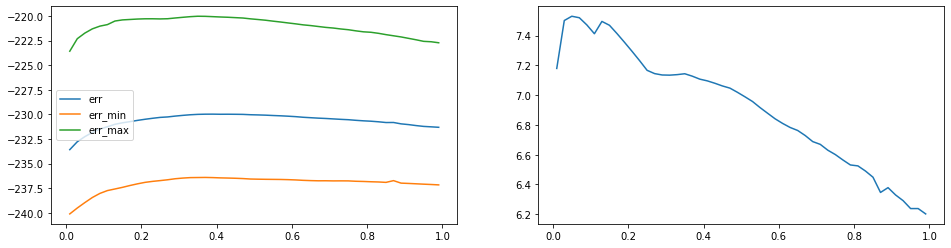

In [20]:
f, ax = plt.subplots(ncols = 2, figsize = (16, 4))
ax[0].plot(alpha, err, label = "err")
ax[0].plot(alpha, err_min, label = "err_min")
ax[0].plot(alpha, err_max, label = "err_max")
ax[0].legend()
ax[1].plot(alpha, err_std)

In [21]:
err_l = pd.DataFrame([alpha, err, err_min, err_max, err_std]).transpose()
err_l.columns = ["alpha", "err", "err_min", "err_max", "err_std"]
print(err_l.sort_values("err", ascending = False).head(1))
print(err_l.sort_values("err_min", ascending = False).head(1))
print(err_l.sort_values("err_max", ascending = False).head(1))

    alpha         err     err_min   err_max   err_std
19   0.39 -229.976098 -236.421303 -220.0737  7.107516
    alpha         err     err_min     err_max   err_std
18   0.37 -229.980295 -236.404412 -220.041385  7.127528
    alpha         err     err_min     err_max  err_std
17   0.35 -229.998387 -236.413664 -220.031788  7.14378


In [22]:
pipeline_l = Pipeline([('encoder', skdm.DataFrameDummies()), 
                        ('l', Lasso(alpha = 0.4, random_state = 1492))])
cv_score_l = cross_val_score(pipeline_l, X_train, y_train, scoring = "neg_mean_absolute_error", cv=5)
print("MAE: ", np.quantile(-cv_score_l,[0.025,0.975]),"\n",np.mean(-cv_score_l))

MAE:  [215.24395543 237.68868624] 
 228.87067220316763


In [23]:
pipeline_l.fit(X_train, y_train)
(y_test-pipeline_l.predict(X_test)).abs().mean()

219.80408581707258

### Random forest

In [24]:
pipeline_rf = Pipeline([('encoder', skdm.DataFrameDummies()), 
                        ('rf', RandomForestRegressor(random_state = 1492))])
cv_score_rf = cross_val_score(pipeline_rf, X_train, y_train, scoring = "neg_mean_absolute_error", cv=5)
print(np.mean(cv_score_rf))

-185.8361501040301


In [25]:
pipeline_rf.get_params()

{'memory': None,
 'steps': [('encoder',
   <sklearn_dummies.base.DataFrameDummies at 0x7fdfad077e80>),
  ('rf', RandomForestRegressor(random_state=1492))],
 'verbose': False,
 'encoder': <sklearn_dummies.base.DataFrameDummies at 0x7fdfad077e80>,
 'rf': RandomForestRegressor(random_state=1492),
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'mse',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 1492,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [26]:
%%time
parameters = {'rf__n_estimators':[100, 250, 500],
              'rf__min_samples_split': [2, 4, 6, 8, 10]}
trees = []
samples = []
err = []
err_std = []
for i in parameters['rf__n_estimators']:
    for k in parameters['rf__min_samples_split']:
        cv = cross_val_score(pipeline_rf.set_params(rf__n_estimators=i, rf__min_samples_split=k), 
                        X_train, y_train, scoring = "neg_mean_absolute_error", cv=3)
        trees.append(i)
        samples.append(k)
        err.append(np.mean(cv))
        err_std.append(np.std(cv))
    print(i, np.max(err))

100 -187.75546709480773
250 -186.95176089300728
500 -186.95176089300728
CPU times: user 10min 23s, sys: 8.87 s, total: 10min 32s
Wall time: 11min 18s


In [27]:
err_rf = pd.DataFrame([trees, samples, err, err_std]).transpose()
err_rf.columns = ["Trees", "Samples", "Err", "Std"]

In [28]:
err_rf.sort_values("Err", ascending = False).head(5)

,Trees,Samples,Err,Std
5,250.0,2.0,-186.951761,1.482764
10,500.0,2.0,-187.012204,1.668315
11,500.0,4.0,-187.081736,1.494654
6,250.0,4.0,-187.099847,1.251616
12,500.0,6.0,-187.240761,1.409022


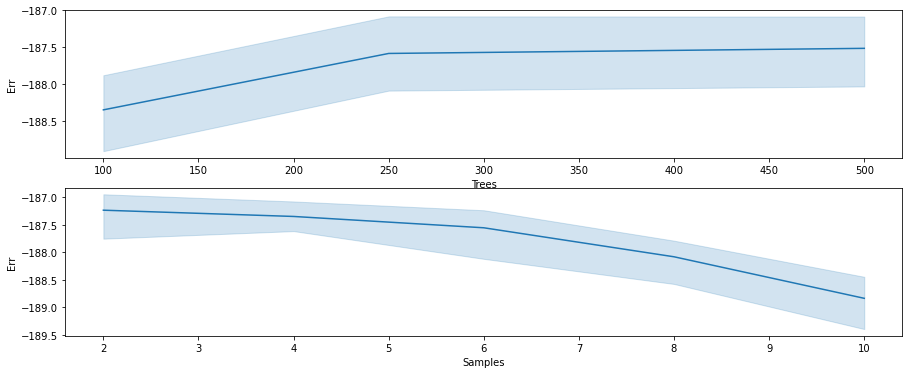

In [29]:
import seaborn as sns
f, ax = plt.subplots(nrows = 2, figsize = (15,6))
sns.lineplot(x = err_rf["Trees"].astype(float), y = err_rf["Err"].astype(float), ax = ax[0])
sns.lineplot(x = err_rf["Samples"].astype(float), y = err_rf["Err"].astype(float), ax = ax[1])

In [30]:
pipeline_rf = Pipeline([('encoder', skdm.DataFrameDummies()), 
                        ('rf', RandomForestRegressor(random_state = 1492))])
pipeline_rf.set_params(rf__n_estimators=500)

Pipeline(steps=[('encoder',
                 <sklearn_dummies.base.DataFrameDummies object at 0x7fdfacb9d190>),
                ('rf',
                 RandomForestRegressor(n_estimators=500, random_state=1492))])

In [31]:
cv = cross_val_score(pipeline_rf, X_train, y_train, scoring = "neg_mean_absolute_error", cv=3)
print(np.mean(cv))

-187.0122038806144


In [32]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('encoder',
                 <sklearn_dummies.base.DataFrameDummies object at 0x7fdfacb9d190>),
                ('rf',
                 RandomForestRegressor(n_estimators=500, random_state=1492))])

In [33]:
(y_test-pipeline_rf.predict(X_test)).abs().mean()

181.3566001215134

In [34]:
test_df = pd.concat([X_test, y_test], axis = 1)
test_df["Error"] = y_test-pipeline_rf.predict(X_test)
test_df.to_csv("test_error.csv")

### Saving the model

In [35]:
import pickle
pickl = {'model': pipeline_rf}
pickle.dump( pickl, open( 'mrm_rf' + ".p", "wb" ) )

In [42]:
round(1323.6188666666667)

1324